# Glacier runoff model for La Paz, Bolivia

## <b> Step 1: Import necessary software packages for graphing and visualization

In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import shapely.geometry as shpg
import os

## <b> Step 2: import and set up OGGM software

In [2]:
from oggm import cfg, utils, workflow, tasks, graphics

In [3]:
# Define the directory path in your home directory
path = '/Users/ziggygoddard/Documents/summer24/OGGM_output' 

In [4]:
# work with parameters 
cfg.initialize(logging_level='WARNING')
cfg.PATHS['working_dir']=path

cfg.PARAMS['store_model_geometry'] = True
cfg.PARAMS['use_multiprocessing'] = True
cfg.PARAMS['continue_on_error']=True #this is to avoid issues with the files with invalid geometries

#You can provide any other dataset to OGGM by setting the climate_file parameter in params.cfg

2024-07-16 14:45:44: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-07-16 14:45:44: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-07-16 14:45:44: oggm.cfg: Multiprocessing: using all available processors (N=8)
2024-07-16 14:45:46: oggm.cfg: PARAMS['store_model_geometry'] changed from `False` to `True`.
2024-07-16 14:45:46: oggm.cfg: Multiprocessing switched ON after user settings.
2024-07-16 14:45:46: oggm.cfg: PARAMS['continue_on_error'] changed from `False` to `True`.


## Step 3: Define glaciers for the run

In [5]:
# Download glacier outlines
# I assume I should access a newer version of the glacier directory?
utils.get_rgi_dir(version='62')  # path to the data after download

'/Users/ziggygoddard/OGGM/rgi/RGIV62'

In [6]:
import oggm
print(oggm.__file__)

/opt/miniconda3/envs/oggm_env/lib/python3.12/site-packages/oggm/__init__.py


In [57]:
# Get rgi region file for region 16 (South America)
fr = utils.get_rgi_region_file(16, version='62')

In [8]:
import geopandas as gpd

# Read the shapefile
gdf = gpd.read_file(fr)

# Print information about the GeoDataFrame
print("Columns in GeoDataFrame:", gdf.columns)
print("Number of features (glaciers):", len(gdf))

# Display the first few rows to inspect the data
print(gdf.head())


Columns in GeoDataFrame: Index(['RGIId', 'GLIMSId', 'BgnDate', 'EndDate', 'CenLon', 'CenLat',
       'O1Region', 'O2Region', 'Area', 'Zmin', 'Zmax', 'Zmed', 'Slope',
       'Aspect', 'Lmax', 'Status', 'Connect', 'Form', 'TermType', 'Surging',
       'Linkages', 'Name', 'check_geom', 'geometry'],
      dtype='object')
Number of features (glaciers): 2939
            RGIId         GLIMSId   BgnDate   EndDate   CenLon   CenLat  \
0  RGI60-16.00001  G290095E16521S  20009999  20030531 -69.9053 -16.5212   
1  RGI60-16.00002  G290088E16520S  20009999  20030531 -69.9117 -16.5196   
2  RGI60-16.00003  G290075E16516S  20009999  20030531 -69.9246 -16.5156   
3  RGI60-16.00004  G290856E16386S  20009999  20030531 -69.1445 -16.3855   
4  RGI60-16.00005  G290859E16384S  20009999  20030531 -69.1411 -16.3840   

  O1Region O2Region   Area  Zmin  ...  Lmax  Status  Connect  Form  TermType  \
0       16        1  0.098  4896  ...   348       0        0     0         0   
1       16        1  0.147  4963  

In [9]:
# Read file as as geopandas
gdf = gpd.read_file(fr)

In [52]:
# Add basin shapefile
path = '~/Documents/summer24/sa_basins/LaPaz_dissolved.shp' 
basin = gpd.read_file(path)

In [53]:
# Select glaciers within the basin
in_bas = [basin.geometry.contains(shpg.Point(x, y))[0] for
          (x, y) in zip(gdf.CenLon, gdf.CenLat)]
gdf_sel = gdf.loc[in_bas]

In [54]:
# Select rgi id's from the gdf_sel file
rgi_ids = gdf_sel['RGIId']

In [55]:
rgi_ids

494     RGI60-16.00495
496     RGI60-16.00497
497     RGI60-16.00498
500     RGI60-16.00501
504     RGI60-16.00505
505     RGI60-16.00506
507     RGI60-16.00508
508     RGI60-16.00509
509     RGI60-16.00510
510     RGI60-16.00511
512     RGI60-16.00513
522     RGI60-16.00523
523     RGI60-16.00524
525     RGI60-16.00526
527     RGI60-16.00528
529     RGI60-16.00530
530     RGI60-16.00531
531     RGI60-16.00532
538     RGI60-16.00539
539     RGI60-16.00540
543     RGI60-16.00544
544     RGI60-16.00545
545     RGI60-16.00546
546     RGI60-16.00547
548     RGI60-16.00549
549     RGI60-16.00550
563     RGI60-16.00564
565     RGI60-16.00566
594     RGI60-16.00595
595     RGI60-16.00596
609     RGI60-16.00610
610     RGI60-16.00611
1441    RGI60-16.01447
1442    RGI60-16.01448
1443    RGI60-16.01449
Name: RGIId, dtype: object

In [14]:
# # Select glaciers within the basin
# in_bas = [basin.geometry.contains(shpg.Point(x, y))[0] for
#           (x, y) in zip(gdf.CenLon, gdf.CenLat)]
# gdf_sel = gdf.loc[in_bas]

# Remove the problematic glaciers
problem_glacier_list = ['RGI60-16.01306']
gdf_sel = gdf_sel[~gdf_sel['RGIId'].isin(problem_glacier_list)]

# Select rgi id's from the gdf_sel file
rgi_ids = gdf_sel['RGIId'].tolist()

## Step 4. Prepare glacier data

In [15]:
# Initiate glacier directory task for each glacier
base_url = 'https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.6/L3-L5_files/2023.3/elev_bands/W5E5_spinup'
gdirs = workflow.init_glacier_directories(rgi_ids,
                                           from_prepro_level=5,
                                           prepro_base_url=base_url,
                                         prepro_border=80)

2024-07-16 14:46:04: oggm.workflow: init_glacier_directories from prepro level 5 on 2 glaciers.
2024-07-16 14:46:04: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 2 glaciers


In [16]:
type(gdirs)

list

In [17]:
# gdirs = []
# for r in rgi_ids:
#     try:
#         gdir_temp = workflow.init_glacier_directories(r,
#                                                    from_prepro_level=5,
#                                                    prepro_base_url=base_url,
#                                                  prepro_border=80)
#         gdirs.append(gdir_temp)
#     except:
#         print('Failed for {}'.format(r))
#         continue

## Does not make correct format of gdirs for later use; also doesn't report any errors
## better luck next time

# Step 5. Initiate climate runs

### I. Run constant climate commitment run

In [18]:
# Initiate run_with_hydro using constant climate
for g in gdirs:
    file_id = '_ct'
    tasks.run_with_hydro(g, run_task=tasks.run_constant_climate, nyears=100, y0=2014, halfsize=5, store_monthly_hydro=True, 
                     output_filesuffix=file_id);

In [19]:
# Export data from constant climate run and compile run output
import datetime
output_path = '~/Documents/summer24/{}-ct_compiled_output.nc'.format(datetime.date.today()) 
new_ds = utils.compile_run_output(gdirs, input_filesuffix=file_id, path=output_path)

2024-07-11 10:45:56: oggm.utils: Applying global task compile_run_output on 2 glaciers
2024-07-11 10:45:56: oggm.utils: Applying compile_run_output on 2 gdirs.


In [20]:
# Load in the glacier data from above (only when data has been saved)
export_date = '2024-07-11'
input_path = '~/Documents/summer24/{}-ct_compiled_output.nc'.format(export_date)
ct_ds = xr.open_dataset(input_path)

In [21]:
# Look at the new dataset
ct_ds

<xarray.Dataset> Size: 75kB
Dimensions:                       (time: 101, rgi_id: 2, month_2d: 12)
Coordinates:
  * time                          (time) float64 808B 0.0 1.0 2.0 ... 99.0 100.0
  * rgi_id                        (rgi_id) <U14 112B 'RGI60-16.01339' 'RGI60-...
    hydro_year                    (time) int64 808B ...
    hydro_month                   (time) int64 808B ...
    calendar_year                 (time) int64 808B ...
    calendar_month                (time) int64 808B ...
  * month_2d                      (month_2d) int64 96B 1 2 3 4 5 ... 9 10 11 12
    calendar_month_2d             (month_2d) int64 96B ...
Data variables: (12/24)
    volume                        (time, rgi_id) float32 808B ...
    volume_bsl                    (time, rgi_id) float32 808B ...
    volume_bwl                    (time, rgi_id) float32 808B ...
    area                          (time, rgi_id) float32 808B ...
    length                        (time, rgi_id) float32 808B ...
    calving                       (time, rgi_id) float32 808B ...
    ...                            ...
    liq_prcp_on_glacier_monthly   (time, month_2d, rgi_id) float32 10kB ...
    snowfall_off_glacier_monthly  (time, month_2d, rgi_id) float32 10kB ...
    snowfall_on_glacier_monthly   (time, month_2d, rgi_id) float32 10kB ...
    water_level                   (rgi_id) float32 8B ...
    glen_a                        (rgi_id) float32 8B ...
    fs                            (rgi_id) float32 8B ...
Attributes:
    description:    OGGM model output
    oggm_version:   1.6.1
    calendar:       365-day no leap
    creation_date:  2024-07-11 14:45:57

### a. Historical run for reference climate period

In [24]:
# Run the historical period with a fixed geometry spinup
for g in gdirs:
    file_id = '_hist_hydro'
    tasks.run_with_hydro(g, run_task=tasks.run_from_climate_data,
                         fixed_geometry_spinup_yr=1990,  # this tells to do spinup
                         ref_area_from_y0=True,  # 
                         store_monthly_hydro=True,
                         output_filesuffix=file_id);
# I think i have to run this every time I start the kernel again so file_id hist_hydro exists for gcm use

In [25]:
# Export data from historic climate run and compile run output
import datetime
output_path = '~/Documents/summer24/{}-hist_hydro_compiled_output.nc'.format(datetime.date.today()) 
new_ds = utils.compile_run_output(gdirs, input_filesuffix=file_id, path=output_path)

2024-07-16 15:36:11: oggm.utils: Applying global task compile_run_output on 2 glaciers
2024-07-16 15:36:11: oggm.utils: Applying compile_run_output on 2 gdirs.


In [26]:
# Load in the glacier data from above (only when data has been saved)
export_date = '2024-07-11'
input_path_hist = '~/Documents/summer24/{}-hist_hydro_compiled_output.nc'.format(export_date)
hist_ds = xr.open_dataset(input_path_hist)

### b. Projection run

<b> Remember: you need to change the GCM for bp and bt

## II. Run CMIP6 projection run

In [27]:
# Is this something I need to/should do? https://docs.oggm.org/en/latest/climate-data.html
from oggm.tasks import process_w5e5_data

In [26]:
# fp='https://cluster.klima.uni-bremen.de/~oggm/cmip6/GCM/{}/{}_{}_r1i1p1f1_pr.nc'

# GCM = ['BCC-CSM2-MR', 'CESM2', 'CESM2-WACCM', 'EC-Earth3', 'EC_Earth3_Veg', 'FGOALS-f3-L', 'GFDL-ESM4', 'INM-CM4-8', 'INM-CM5-0', 'MP1-ESM1-2-HR', 'MRI-ESM2-0', 'NorESM2-MM']

# SSP = 'ssp126'

# this_filename_precip = fp.format(GCM, GCM, SSP)

# print(this_filename_precip)

In [33]:
from oggm.shop import gcm_climate

# all_members = ['BCC-CSM2-MR', 'CESM2', 'CESM2-WACCM', 'EC-Earth3', 'FGOALS-f3-L', 'GFDL-ESM4',
#                 'INM-CM4-8', 'INM-CM5-0', 'MRI-ESM2-0', 'NorESM2-MM']

all_members = ['EC-Earth3-Veg', 'MPI-ESM1-2-HR']

# problem gcm: 'MPI-ESM1-2-HR'

bp = 'https://cluster.klima.uni-bremen.de/~oggm/cmip6/GCM/{}/{}_{}_r1i1p1f1_pr.nc'
bt = 'https://cluster.klima.uni-bremen.de/~oggm/cmip6/GCM/{}/{}_{}_r1i1p1f1_tas.nc'

# Download the three main SSPs
for member in all_members:
    for ssp in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
        rid = '_CMIP6_{}_{}'.format(member, ssp)
        output_path = os.path.expanduser(f'~/Documents/summer24/{datetime.date.today()}-gcm_data_{member}_{ssp}_compiled_output.nc')
        
        # Check if the file already exists
        if not os.path.exists(output_path):
            # Download the files
            ft = utils.file_downloader(bt.format(member, member, ssp))
            fp = utils.file_downloader(bp.format(member, member, ssp))
            
            # Bias correct them
            workflow.execute_entity_task(gcm_climate.process_cmip_data, gdirs, 
                                         filesuffix='_CMIP6_{}_{}'.format(member, ssp), 
                                         fpath_temp=ft, fpath_precip=fp)
        else:
            print(f"Skipping download for {output_path}. File already exists.")

        # Run tasks if necessary (e.g., hydrological model runs)
        workflow.execute_entity_task(tasks.run_with_hydro, gdirs,
                                     run_task=tasks.run_from_climate_data, ys=2020,
                                     climate_filename='gcm_data',
                                     climate_input_filesuffix=rid,
                                     init_model_filesuffix='_spinup_historical',
                                     output_filesuffix=rid,
                                     store_monthly_hydro=True)
        
        # Compile run output
        new_ds = utils.compile_run_output(gdirs, input_filesuffix=rid, path=output_path)

# # Download the three main SSPs
# for member in all_members:
#     for ssp in ['ssp126', 'ssp245', 'ssp370', 'ssp585']: 
#         # Download the files
#         # print(bt.format(member, member, ssp))
#         ft = utils.file_downloader(bt.format(member, member, ssp))
#         fp = utils.file_downloader(bp.format(member, member, ssp))
#         # bias correct them
#         workflow.execute_entity_task(gcm_climate.process_cmip_data, gdirs, 
#                                       filesuffix='_CMIP6_{}_{}'.format(member, ssp),  # recognize the climate file for later
#                                       fpath_temp=ft,  # temperature projections
#                                       fpath_precip=fp,  # precip projections
#                                       );

2024-07-16 15:51:33: oggm.workflow: Execute entity tasks [run_with_hydro] on 2 glaciers


Skipping download for /Users/ziggygoddard/Documents/summer24/2024-07-16-gcm_data_EC-Earth3-Veg_ssp126_compiled_output.nc. File already exists.


2024-07-16 15:51:33: oggm.utils: Applying global task compile_run_output on 2 glaciers
2024-07-16 15:51:33: oggm.utils: Applying compile_run_output on 2 gdirs.
2024-07-16 15:51:33: oggm.workflow: Execute entity tasks [run_with_hydro] on 2 glaciers


Skipping download for /Users/ziggygoddard/Documents/summer24/2024-07-16-gcm_data_EC-Earth3-Veg_ssp245_compiled_output.nc. File already exists.


2024-07-16 15:51:34: oggm.utils: Applying global task compile_run_output on 2 glaciers
2024-07-16 15:51:34: oggm.utils: Applying compile_run_output on 2 gdirs.
2024-07-16 15:51:34: oggm.workflow: Execute entity tasks [run_with_hydro] on 2 glaciers


Skipping download for /Users/ziggygoddard/Documents/summer24/2024-07-16-gcm_data_EC-Earth3-Veg_ssp370_compiled_output.nc. File already exists.


2024-07-16 15:51:35: oggm.utils: Applying global task compile_run_output on 2 glaciers
2024-07-16 15:51:35: oggm.utils: Applying compile_run_output on 2 gdirs.
2024-07-16 15:51:35: oggm.workflow: Execute entity tasks [run_with_hydro] on 2 glaciers


Skipping download for /Users/ziggygoddard/Documents/summer24/2024-07-16-gcm_data_EC-Earth3-Veg_ssp585_compiled_output.nc. File already exists.


2024-07-16 15:51:36: oggm.utils: Applying global task compile_run_output on 2 glaciers
2024-07-16 15:51:36: oggm.utils: Applying compile_run_output on 2 gdirs.
2024-07-16 15:51:36: oggm.workflow: Execute entity tasks [run_with_hydro] on 2 glaciers


Skipping download for /Users/ziggygoddard/Documents/summer24/2024-07-16-gcm_data_MPI-ESM1-2-HR_ssp126_compiled_output.nc. File already exists.


2024-07-16 15:51:37: oggm.utils: Applying global task compile_run_output on 2 glaciers
2024-07-16 15:51:37: oggm.utils: Applying compile_run_output on 2 gdirs.
2024-07-16 15:51:37: oggm.workflow: Execute entity tasks [run_with_hydro] on 2 glaciers


Skipping download for /Users/ziggygoddard/Documents/summer24/2024-07-16-gcm_data_MPI-ESM1-2-HR_ssp245_compiled_output.nc. File already exists.


2024-07-16 15:51:38: oggm.utils: Applying global task compile_run_output on 2 glaciers
2024-07-16 15:51:38: oggm.utils: Applying compile_run_output on 2 gdirs.
2024-07-16 15:51:38: oggm.workflow: Execute entity tasks [run_with_hydro] on 2 glaciers


Skipping download for /Users/ziggygoddard/Documents/summer24/2024-07-16-gcm_data_MPI-ESM1-2-HR_ssp370_compiled_output.nc. File already exists.


2024-07-16 15:51:38: oggm.utils: Applying global task compile_run_output on 2 glaciers
2024-07-16 15:51:38: oggm.utils: Applying compile_run_output on 2 gdirs.
2024-07-16 15:51:39: oggm.workflow: Execute entity tasks [run_with_hydro] on 2 glaciers


Skipping download for /Users/ziggygoddard/Documents/summer24/2024-07-16-gcm_data_MPI-ESM1-2-HR_ssp585_compiled_output.nc. File already exists.


2024-07-16 15:51:39: oggm.utils: Applying global task compile_run_output on 2 glaciers
2024-07-16 15:51:39: oggm.utils: Applying compile_run_output on 2 gdirs.


In [34]:
for member in all_members: # added this, it ensures that files will not be overwritten
    for ssp in ['ssp126', 'ssp245', 'ssp370', 'ssp585']: # add ssp245
        rid = '_CMIP6_{}_{}'.format(member, ssp)
        workflow.execute_entity_task(tasks.run_with_hydro, gdirs,
                                 run_task=tasks.run_from_climate_data, ys=2020,
                                 # use gcm_data, not climate_historical
                                 climate_filename='gcm_data',
                                 # use the chosen scenario
                                 climate_input_filesuffix=rid,
                                 # this is important! Start from 2020 glacier
                                 init_model_filesuffix='_spinup_historical',
                                 # recognize the run for later
                                 output_filesuffix=rid,
                                 # add monthly diagnostics
                                 store_monthly_hydro=True);

2024-07-16 16:46:05: oggm.workflow: Execute entity tasks [run_with_hydro] on 2 glaciers
2024-07-16 16:46:06: oggm.workflow: Execute entity tasks [run_with_hydro] on 2 glaciers
2024-07-16 16:46:07: oggm.workflow: Execute entity tasks [run_with_hydro] on 2 glaciers
2024-07-16 16:46:09: oggm.workflow: Execute entity tasks [run_with_hydro] on 2 glaciers
2024-07-16 16:46:10: oggm.workflow: Execute entity tasks [run_with_hydro] on 2 glaciers
2024-07-16 16:46:11: oggm.workflow: Execute entity tasks [run_with_hydro] on 2 glaciers
2024-07-16 16:46:12: oggm.workflow: Execute entity tasks [run_with_hydro] on 2 glaciers
2024-07-16 16:46:12: oggm.workflow: Execute entity tasks [run_with_hydro] on 2 glaciers


In [35]:
# This is unchanged
new_ds_nor = utils.compile_run_output(gdirs, input_filesuffix=rid)

2024-07-16 16:46:23: oggm.utils: Applying global task compile_run_output on 2 glaciers
2024-07-16 16:46:23: oggm.utils: Applying compile_run_output on 2 gdirs.


In [36]:
# Changes explained by ChatGPT; again, unsure how this will affect pathway
# Export data from climate run and compile run output
# First for-loop ensures that files will not be overwritten
import datetime
for member in all_members:
    for ssp in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
        rid = '_CMIP6_{}_{}'.format(member, ssp)
        output_path = os.path.expanduser(f'~/Documents/summer24/{datetime.date.today()}-gcm_data_{member}_{ssp}_compiled_output.nc')
        new_ds = utils.compile_run_output(gdirs, input_filesuffix=rid, path=output_path)

2024-07-16 16:46:34: oggm.utils: Applying global task compile_run_output on 2 glaciers
2024-07-16 16:46:34: oggm.utils: Applying compile_run_output on 2 gdirs.
2024-07-16 16:46:34: oggm.utils: Applying global task compile_run_output on 2 glaciers
2024-07-16 16:46:34: oggm.utils: Applying compile_run_output on 2 gdirs.
2024-07-16 16:46:34: oggm.utils: Applying global task compile_run_output on 2 glaciers
2024-07-16 16:46:34: oggm.utils: Applying compile_run_output on 2 gdirs.
2024-07-16 16:46:35: oggm.utils: Applying global task compile_run_output on 2 glaciers
2024-07-16 16:46:35: oggm.utils: Applying compile_run_output on 2 gdirs.
2024-07-16 16:46:35: oggm.utils: Applying global task compile_run_output on 2 glaciers
2024-07-16 16:46:35: oggm.utils: Applying compile_run_output on 2 gdirs.
2024-07-16 16:46:35: oggm.utils: Applying global task compile_run_output on 2 glaciers
2024-07-16 16:46:35: oggm.utils: Applying compile_run_output on 2 gdirs.
2024-07-16 16:46:35: oggm.utils: Applyin

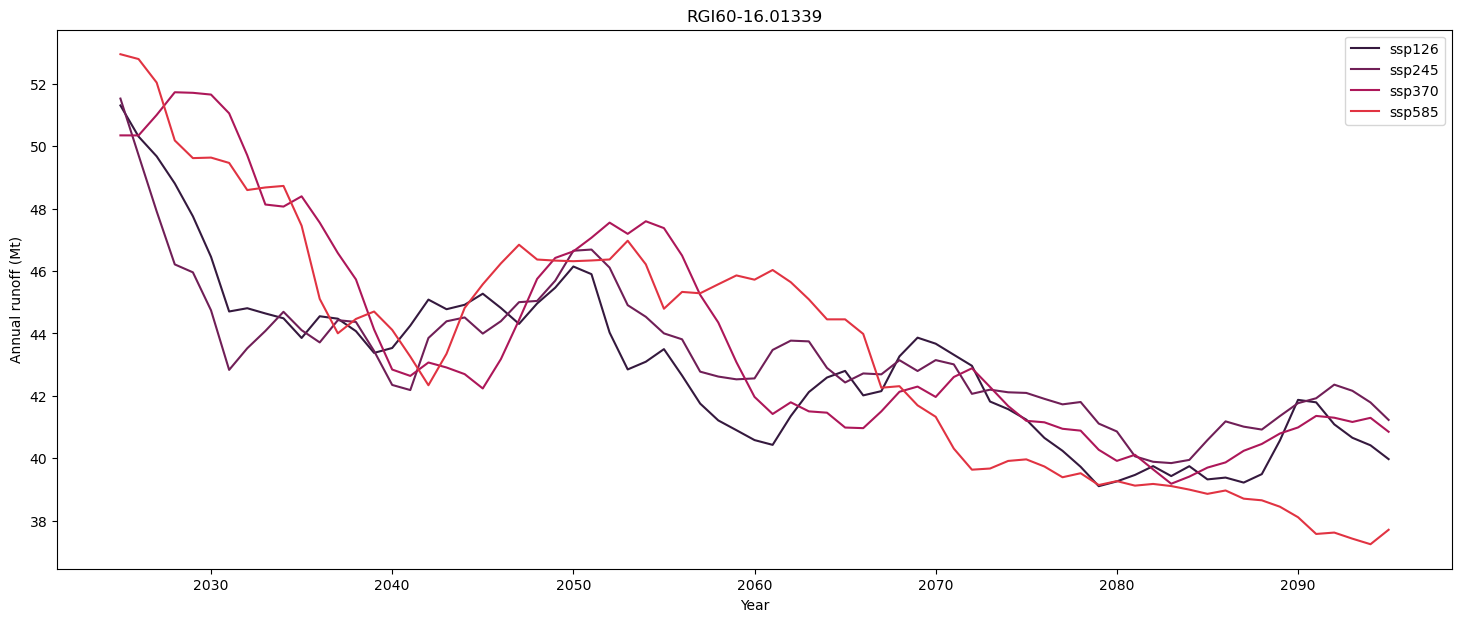

In [43]:
# Create the figure
f, ax = plt.subplots(figsize=(18, 7), sharex=True)
# Loop over all scenarios
for i, ssp in enumerate(['ssp126', 'ssp245', 'ssp370', 'ssp585']):
    file_id = '_CMIP6_{}_{}'.format(member, ssp)
    # Open the data, gdirs[0] correspond to Hintereisferner.
    with xr.open_dataset(gdirs[0].get_filepath('model_diagnostics', filesuffix=file_id)) as ds:
        # Load the data into a dataframe
        ds = ds.isel(time=slice(0, -1)).load()

    # Select annual variables
    sel_vars = [v for v in ds.variables if 'month_2d' not in ds[v].dims]
    # And create a dataframe
    df_annual = ds[sel_vars].to_dataframe()

    # Select the variables relevant for runoff.
    runoff_vars = ['melt_off_glacier', 'melt_on_glacier', 'liq_prcp_off_glacier', 'liq_prcp_on_glacier']
    # Convert to mega tonnes instead of kg.
    df_runoff = df_annual[runoff_vars].clip(0) * 1e-9
    # Sum the variables each year "axis=1", take the 11 year rolling mean and plot it.
    df_roll = df_runoff.sum(axis=1).rolling(window=11, center=True).mean()
    df_roll.plot(ax=ax, label=ssp, color=sns.color_palette("rocket")[i])

ax.set_ylabel('Annual runoff (Mt)'); ax.set_xlabel('Year'); plt.title(gdirs[0].rgi_id); plt.legend();

# for g in gdirs:
    print(g.get_filepath('model_geometry', filesuffix='_spinup_historical'))

In [33]:
for ssp in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
    file_id = '_CMIP6_{}_{}'.format(member, ssp)
    print(gdirs[0].get_filepath('model_diagnostics', filesuffix=file_id))

/Users/ziggygoddard/Documents/summer24/OGGM_output/per_glacier/RGI60-16/RGI60-16.01/RGI60-16.01307/model_diagnostics_CMIP6_MRI-ESM2-0_ssp126.nc
/Users/ziggygoddard/Documents/summer24/OGGM_output/per_glacier/RGI60-16/RGI60-16.01/RGI60-16.01307/model_diagnostics_CMIP6_MRI-ESM2-0_ssp245.nc
/Users/ziggygoddard/Documents/summer24/OGGM_output/per_glacier/RGI60-16/RGI60-16.01/RGI60-16.01307/model_diagnostics_CMIP6_MRI-ESM2-0_ssp370.nc
/Users/ziggygoddard/Documents/summer24/OGGM_output/per_glacier/RGI60-16/RGI60-16.01/RGI60-16.01307/model_diagnostics_CMIP6_MRI-ESM2-0_ssp585.nc


In [34]:
import os

for ssp in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
    file_id = '_CMIP6_{}_{}'.format(member, ssp)
    filepath = gdirs[0].get_filepath('model_diagnostics', filesuffix=file_id)
    if not os.path.isfile(filepath):
        print(f"File {filepath} does not exist or is not accessible.")
    else:
        print(f"File {filepath} is present and accessible.")

File /Users/ziggygoddard/Documents/summer24/OGGM_output/per_glacier/RGI60-16/RGI60-16.01/RGI60-16.01307/model_diagnostics_CMIP6_MRI-ESM2-0_ssp126.nc is present and accessible.
File /Users/ziggygoddard/Documents/summer24/OGGM_output/per_glacier/RGI60-16/RGI60-16.01/RGI60-16.01307/model_diagnostics_CMIP6_MRI-ESM2-0_ssp245.nc is present and accessible.
File /Users/ziggygoddard/Documents/summer24/OGGM_output/per_glacier/RGI60-16/RGI60-16.01/RGI60-16.01307/model_diagnostics_CMIP6_MRI-ESM2-0_ssp370.nc is present and accessible.
File /Users/ziggygoddard/Documents/summer24/OGGM_output/per_glacier/RGI60-16/RGI60-16.01/RGI60-16.01307/model_diagnostics_CMIP6_MRI-ESM2-0_ssp585.nc is present and accessible.


In [35]:
import xarray as xr

file_id = '_CMIP6_{}_{}'.format(member, 'ssp126')
filepath = gdirs[0].get_filepath('model_diagnostics', filesuffix=file_id)
try:
    with xr.open_dataset(filepath) as ds:
        print(ds)
except Exception as e:
    print(f"Error opening file {filepath}: {e}")

<xarray.Dataset> Size: 208kB
Dimensions:                       (time: 282, month_2d: 12)
Coordinates:
  * time                          (time) float64 2kB 2.02e+03 ... 2.301e+03
    calendar_year                 (time) int64 2kB ...
    calendar_month                (time) int64 2kB ...
    hydro_year                    (time) int64 2kB ...
    hydro_month                   (time) int64 2kB ...
  * month_2d                      (month_2d) int64 96B 1 2 3 4 5 ... 9 10 11 12
    hydro_month_2d                (month_2d) int64 96B ...
    calendar_month_2d             (month_2d) int64 96B ...
Data variables: (12/21)
    volume_m3                     (time) float64 2kB ...
    volume_bsl_m3                 (time) float64 2kB ...
    volume_bwl_m3                 (time) float64 2kB ...
    area_m2                       (time) float64 2kB ...
    length_m                      (time) float64 2kB ...
    calving_m3                    (time) float64 2kB ...
    ...                            ...

In [37]:
# This is how to check if files for individual glaciers exist

import os

spinup_path = '/Users/ziggygoddard/Documents/summer24/OGGM_output/per_glacier/RGI60-16/RGI60-16.02/'
for glacier_id in ['RGI60-16.02945']:  # Add other glacier IDs as needed
    file_path = os.path.join(spinup_path, glacier_id, 'model_geometry_spinup_historical.nc')
    if not os.path.isfile(file_path):
        print(f"Missing spinup file: {file_path}")

# missing 01306, 02942-02945 